---
# Apples to Apples
### John Thurman
---

## Table of Contents
* #### [Introduction](#Introduction)
    * [Define functions](#DefineFunctions)
    * [Loading Data](#LoadingData)
    * [Data exploration](#DataExploration)
* #### [Modelling fruit 360 data](#ModellingSection1)
    * [Random Forest Benchmark](#Benchmark)
    * [2 Convolution CNN](#Model1)
    * [4 Convolution CNN](#Model2)
    * [Transfer learning](#Model3)
    * [General Comments](#Comments1)
* #### [Modelling flickr data](#ModellingSection2)
    * [4 Convolution CNN](#Model4)
    * [Transfer learning](#Model5)
    * [General Comments](#Comments2)
* #### [Reduced fruit subset](#ModellingSection3)
    * [4 Convolutions CNN](#Model6)
    * [Transfer learning](#Model7)
    * [Hyper-parameter tuning](#Hyperparam)
    * [General Comments](#Comments3)
* #### [Other](#Other)
    * [Image Augmentation](#ImageAugmentation)





Load the appropriate libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import pickle
import os
import glob

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy, sparse_top_k_categorical_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight

print('Tensorflow version \t:', tf.__version__)
print(tf.test.is_gpu_available(), tf.test.is_built_with_cuda(), tf.test.gpu_device_name())

Using TensorFlow backend.
W0325 11:51:22.076295 24004 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Tensorflow version 	: 1.10.0
True True /device:GPU:0


<a id="Introduction"> </a>
# Introduction

The objective of this project is to determine whether image classification techniques can be used to distinguish between different types of fruit. The project looks at 4 general types of model:
* Random Forest Classifier (Used as a benchmark)
* A Convoltional Neural network (CNN) with 2 convolutional layers
* CNN with 4 convolutional layers
* CNN using transfer learning from a mobilenet (V2) model that has been trained on the Imagenet dataset.

The data used for this project has come from two sources:
* 'fruit-360' dataset produced by Horea Muresan, Mihai Oltean, and available at kaggle 
<a href='https://www.kaggle.com/moltean/fruits'> here </a> 
* A dataset that was compiled using the Flickr API with additional manual cleaning. A separate jupyter notebook has been included detailing the steps taken to collect this data

This project has been split into two sections, seperated by the two of data sources

<a id="DefineFunctions"></a>
# Defining useful functions 

These functions are used throughout the document in the analysis

In [2]:
#Metric for defining success. In addition to accr
def custom_accuracy(ytrue, ypred):
    '''
    An accuracy where we determine whether we manage to guess the product within the top 4 tries.
    '''
    return sparse_top_k_categorical_accuracy(ytrue, ypred, k=4)

# functions for plotting learning
def plt_history(history):
    '''
    For use with a keras based model.
    This model will plot the loss, accuracy and 'top4 accuracy' per epoch.
    '''
    
    plt.figure(figsize=[20,6]);
    for counter, metric in enumerate(['loss', 'acc', 'custom_accuracy']):
    
        val_metric = 'val_'+metric
        plt.subplot(1,3,counter+1)
        plt.plot(history.history[metric],'r',linewidth=3.0);
        plt.plot(history.history[val_metric],'b',linewidth=3.0);
        plt.legend(['Training '+ metric, 'Validation '+metric,],fontsize=18);
        plt.xlabel('Epochs ',fontsize=16);
        plt.ylabel(metric ,fontsize=16);
        plt.title(metric +' Curves',fontsize=16);   

def convert_to_supergroup(x):
    '''
    The fruit-360 data comes in 95 different varieties typically sub-species (e.g. Braeburn). The Flicker data comes
    just over 50 varieties typically super species (e.g. Apple). This converst sub-species to super specie.
    '''
    
    df_supergroup = pd.read_csv('./data/FruitCategories.csv')
    df_x = pd.DataFrame(x, columns=['SubCategory'])
    return list((pd.merge(df_x, df_supergroup, on='SubCategory', how='left').loc[:,'Category']).values)

def plot_first_group(data, prediction_labels, truth_labels, number=15):
    '''
    This draws the first n
    '''
    plt.figure(figsize=(20,10))
    for count, photo in enumerate(prediction_labels[:number]):
        rows = (number-1)//5+1
        plt.subplot(rows,5, count+1)
        b,g,r = cv2.split(data[count,:,:,:])       
        rgb_img = cv2.merge([r,g,b]) 
        plt.imshow(rgb_img)
        plt.title(photo+'({}) ' .format(truth_labels[count]))
 
def load_data(directory, maxData=None, randomState=1):
    '''
    Loads the different data sets from file. Smaller (random) subsets can be taken for experimenting by using the MaxData and 
    random state parameters
    '''
    #Get list of all images in directory
    imagePaths = glob.glob(directory+'/*/*.jpg', recursive=True)
    
    if maxData is not None:
        np.random.set_state=randomState
        imagePaths = np.random.choice(imagePaths,size=maxData)
          
    X =[]
    y =[]
    for path in imagePaths:
        label = path.split("\\")[-2]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        X.append(image)
        y.append(label)
        
    return np.array(X), np.array(y)

<a id='LoadingData'></a>
# Load data

#### Fruit 360 data set

In [3]:
# Load training set
X,y = load_data('./data/fruits/fruits-360/Training',maxData=20000)

#Preprocess the data using a label encoder and diving by 255
label_encoder = LabelEncoder()
label_encoder.fit(y)
X = X/255
y = label_encoder.transform(y)

# Create train, validation split
X_train, X_val, y_train, y_val = train_test_split(X, y)

# Save the label encoder to file
fileObject = open('labelEncoding.pkl','wb')
pickle.dump(label_encoder,fileObject)
fileObject.close()

In [4]:
# test data is a hold out set specificly identified in the data set. Load this data and preprocess
X_test,y_test = load_data('./data/fruits/fruits-360/Test', maxData=10000)
X_test = X_test/255
y_test = label_encoder.transform(y_test)

In [5]:
INPUTSHAPE = (100,100,3)
OUTPUTSHAPE = len(np.unique(y))
del X, y #To free up space as otherwise there is a duplication of this data

#### Flickr data

In [66]:
# load data
X_flickr, y_flickr = load_data('./data/flickr')
X_flickr = X_flickr/255

#Create the reduced dataset:
fruitsubset = ['Strawberry', 'Apple', 'Lemon', 'Orange', 'Mango', 'Banana', 'Grape', 'Passion Fruit', 'Peach', 'Pineapple', 'Lime']
infruitsubset = np.in1d(y_flickr, fruitsubset)
X_flickr_subset = X_flickr[infruitsubset]
y_flickr_subset = y_flickr[infruitsubset]

#need a new encoder as the data has different labels than the fruit 360 dataset
label_encoder_flickr = LabelEncoder()

#transformation on data
y_flickr = label_encoder_flickr.fit_transform(y_flickr)
X_flickr_train, X_flickr_test, y_flickr_train, y_flickr_test = train_test_split(X_flickr, y_flickr,  \
                                                                                test_size=0.1, train_size=0.9, stratify=y_flickr)
X_flickr_train, X_flickr_val, y_flickr_train, y_flickr_val = train_test_split(X_flickr_train, y_flickr_train, \
                                                                              test_size=0.2, train_size=0.8, stratify=y_flickr_train)

# Save the label encoder to use in predictions in a web app
fileObject = open('labelEncodingFlickr.pkl','wb')
pickle.dump(label_encoder_flickr,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKR = len(np.unique(y_flickr))

In [67]:
#need a new encoder as the data has different labels than the fruit 360 dataset (and smaller than the other flickr encoding)
label_encoder_flickr_subset = LabelEncoder()

#transformation on data
y_flickr_subset = label_encoder_flickr_subset.fit_transform(y_flickr_subset)
X_flickr_subset_train, X_flickr_subset_test, y_flickr_subset_train, y_flickr_subset_test = train_test_split(X_flickr_subset, y_flickr_subset,  test_size=0.1, train_size=0.9, stratify=y_flickr_subset)
X_flickr_subset_train, X_flickr_subset_val, y_flickr_subset_train, y_flickr_subset_val = train_test_split(X_flickr_subset_train, y_flickr_subset_train,  test_size=0.2, train_size=0.8, stratify=y_flickr_subset_train)

# Save the label encoder to use in predictions in a web app
fileObject = open('labelEncodingFlickrSubset.pkl','wb')
pickle.dump(label_encoder_flickr_subset,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKRSUBSET = len(np.unique(y_flickr_subset))

#To free up space as otherwise there is a duplication of this data
del X_flickr, y_flickr

In [68]:
class_weights_flickr = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_flickr_train),
                                                 y_flickr_train)

class_weights_flickr_subset = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_flickr_subset_train),
                                                 y_flickr_subset_train)

# Data Exploration <a id='DataExploration'></a>

In seperate Notebook

<a id=ModellingSection1></a>
<a id=Benchmark></a>
# Modelling using fruit 360 training data
## Random Forest Benchmark

Completed for Flickr data and the fruit-360 dataset

In [71]:
#Flatten the data
# Note that the data in the fruit 360 dataset is made up of 60000*30000*8(byte) floats -> This is 13GB of RAM needed to store. 
# Making a copy can be quite painful!
X_train_flat = X_train.reshape((len(X_train),30000))
X_test_flat = X_test.reshape((len(X_test), 30000))

X_flickr_train_flat = X_flickr_train.reshape((len(X_flickr_train),30000))
X_flickr_val_flat = X_flickr_val.reshape((len(X_flickr_val), 30000))

In [11]:
clf = RandomForestClassifier(n_estimators=10)

clf.fit(X_train_flat, y_train)
print('Training accuracy \t: %.3f' % clf.score(X_train_flat, y_train))
print('Test accuracy \t\t: %.3f' % clf.score(X_test_flat, y_test))


Training accuracy 	: 1.000
Test accuracy 		: 0.914


In [72]:
clf = RandomForestClassifier(n_estimators=10)

clf.fit(X_flickr_train_flat, y_flickr_train)
print('Training accuracy \t: %.3f' % clf.score(X_flickr_train_flat, y_flickr_train))
print('Test accuracy \t\t: %.3f'  % clf.score(X_flickr_val_flat, y_flickr_val))

Training accuracy 	: 0.995
Test accuracy 		: 0.228


In [13]:
del X_train_flat, X_test_flat, X_flickr_train_flat #create space

<a id='Model1'> </a>
### Model 1 - Two layer convolutional neural network

In [14]:
#Define a model:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=INPUTSHAPE))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(264, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(OUTPUTSHAPE, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 264)               8651016   
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
__________

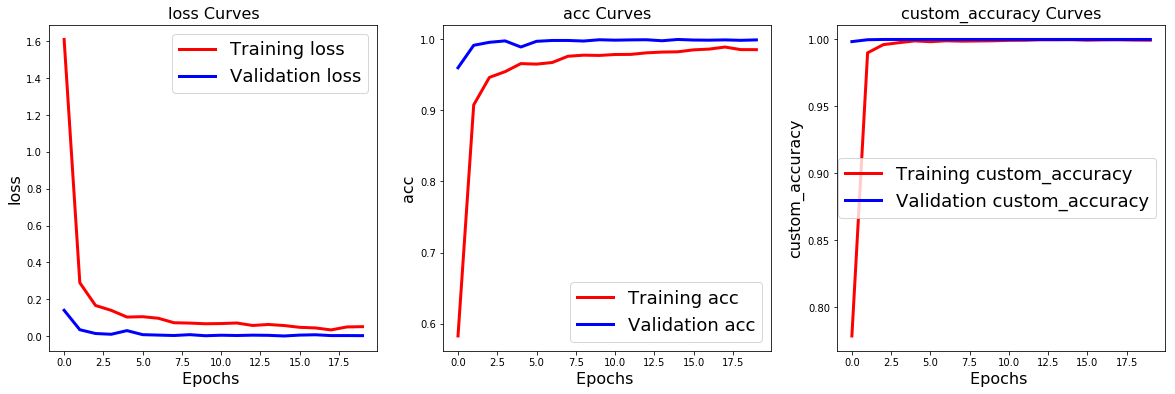

In [15]:
# training model with early stopping
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=5, verbose=0, mode='auto')
         
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    epochs=100, verbose=0)

#plot the training history
plt_history(history)

In [16]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',model.evaluate(X_test, y_test, verbose=0)[1])

print('The accuracy of the model on a set of real life images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple) and not 
# the subclass (e.g. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model.predict_classes(X_flickr_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_test)))

The accuracy of the model on a test set:
Accuracy 	: 0.9663
The accuracy of the model on a set of real life images:
Accuracy 	: 0.072


In [17]:
#save the model
path_weights = './saved_models/model1/weights.h5'
path_model = './saved_models/model1/model.json'

#Save Model
model_json = model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model.save_weights(path_weights)

In [18]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

This model made an improvement on the benchmark random forest classifier
<a id='Model2'></a>

## Model 2 - 4 layer convolutional neural network

In [56]:
class CNN4LayerModel():
    
    def __init__(self, outputshape, 
                 conv1filter = 32, conv1size=3, stride1=2,
                 conv2filter=32, conv2size=3,
                 conv3filter=64, conv3size=3,
                 conv4filter=64, conv4size=3, 
                 denseNodes1=128, dropout1=0.5):
        #Save params for reporting
        self.saved_arguments = locals()
    
        #Create Model
        self.model = Sequential()
        self.model.add(Conv2D(conv1filter,(conv1size,conv1size),padding='same',strides=(stride1,stride1),activation='relu'))
        self.model.add(Conv2D(conv2filter, (conv2size, conv2size),padding ='same',activation='relu'))
        self.model.add(MaxPooling2D(2,2))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(conv3filter, (conv3size, conv3size),padding ='same',activation='relu'))
        self.model.add(Conv2D(conv4filter, (conv4size, conv4size),padding ='same',activation='relu'))
        self.model.add(MaxPooling2D(2,2))
        self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(denseNodes1, activation='relu'))
        self.model.add(Dropout(dropout1))
        self.model.add(BatchNormalization())
        self.model.add(Dense(outputshape, activation='softmax'))
    
    def compile_model(self, optimizer='adam'):
        #compile model
        self.model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', custom_accuracy]) 
        
    def summarise(self):
        self.model.summary()

    def get_results(self, X_train, y_train, X_val, y_val, X_test, y_test, verbose=0, epochs=100, patience=10):
        #Run model
        cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=patience, verbose=0, mode='auto')
        
        self.history = self.model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    epochs=epochs, verbose=verbose)
        
        #Get scores            
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        Accuracyscore = scores[1]
        K_Accuracyscore = scores[2]
                    
        return {**self.saved_arguments, 
                'Training Accuracy' : self.history.history['acc'][-1],
                'Training Top-4 Accuracy': self.history.history['custom_accuracy'][-1],
                'Validation Accuracy':self.history.history['val_acc'][-1],
                'Validation Top-4 Accuracy': self.history.history['val_custom_accuracy'][-1],
                'Test Accuracy': scores[1],
                'Test Top-4 Accuracy': scores[2]}
    
    def plot_results(self):
        plt_history(self.history)
                                    

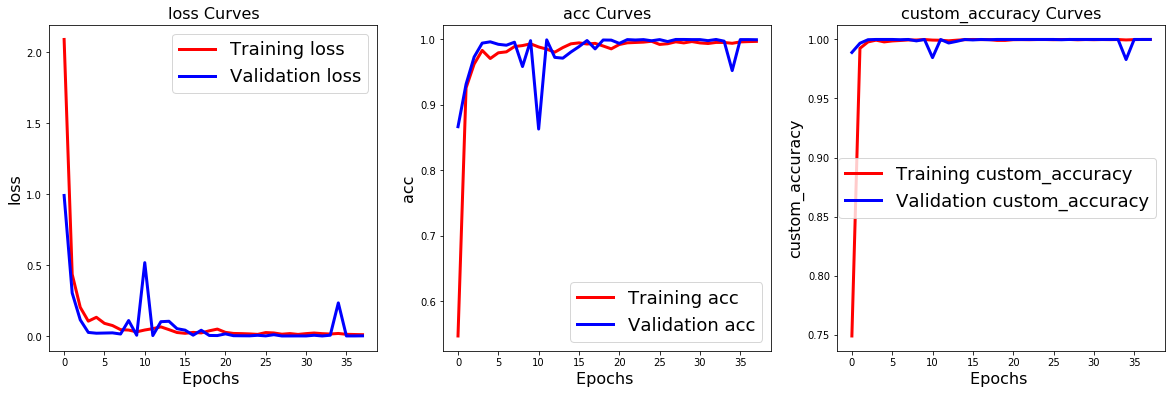

In [20]:
model2 = CNN4LayerModel(OUTPUTSHAPE)
model2.compile_model()
results = model2.get_results(X_train, y_train,X_val, y_val, X_test, y_test, verbose=0)
model2.plot_results()

In [21]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

print('The accuracy of the model on a set of real life images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple vs. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model2.model.predict_classes(X_flickr_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_test)))

The accuracy of the model on a test set:
Accuracy 	: 0.968
The accuracy of the model on a set of real life images:
Accuracy 	: 0.049


In [22]:
path_weights = './saved_models/model2/weights.h5'
path_model = './saved_models/model2/model.json'

#Save Model
model_json = model2.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model2.model.save_weights(path_weights)

In [23]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

<a id='Model3'></a>
# Model 3 - Transfer learning model

In [102]:
class TransferLearningModel():
    
    def __init__(self, outputshape, dropout1=0.5, dropout2=0.5, denseNodes=264, \
                 featureVectorString='https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2'):
        #Save params for reporting
        self.saved_arguments = locals()
    
        #Get feature vector
        module = hub.Module(featureVectorString, trainable=False, name='featureVector')
        height, width = hub.get_expected_image_size(module)

        resize_layer = Lambda(lambda x: tf.image.resize_images(x, (height,width)), input_shape = INPUTSHAPE)
        FeatureVector128 = Lambda(module, input_shape = [height,width,3])
        
        #Create Model
        self.model = Sequential()
        self.model.add(resize_layer)
        self.model.add(FeatureVector128)
        self.model.add(Dropout(dropout1))
        self.model.add(Dense(denseNodes, activation='relu'))
        self.model.add(Dropout(dropout2))
        self.model.add(Dense(outputshape, activation='softmax'))
    
    def compile_model(self, optimizer='adam'):
        #compile model
        self.model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', custom_accuracy])  

    def get_results(self, X_train, y_train, X_val, y_val, X_test, y_test, verbose=0, epochs=100, patience=5, class_weight=None):
        #Run model
        cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=patience, verbose=0, mode='auto')
        
        self.history = self.model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    class_weight=class_weight,
                    epochs=epochs, verbose=verbose)
        
        #Get scores            
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        Accuracyscore = scores[1]
        K_Accuracyscore = scores[2]
                    
        return {**self.saved_arguments, 
                'Training Accuracy' : self.history.history['acc'][-1],
                'Training Top-4 Accuracy': self.history.history['custom_accuracy'][-1],
                'Validation Accuracy':self.history.history['val_acc'][-1],
                'Validation Top-4 Accuracy': self.history.history['val_custom_accuracy'][-1],
                'Test Accuracy': scores[1],
                'Test Top-4 Accuracy': scores[2]}
    
    def plot_results(self):
        plt_history(self.history)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 12:30:12.219323 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


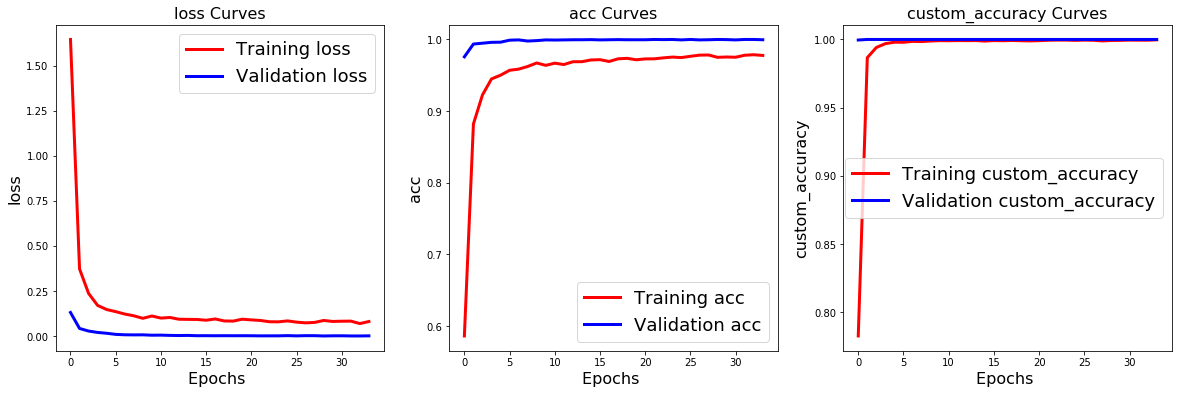

In [25]:
model3 = TransferLearningModel(OUTPUTSHAPE)
model3.compile_model()
#model3.summarise()
results = model3.get_results(X_train, y_train,X_val, y_val, X_test, y_test, verbose=0)
model3.plot_results()

In [26]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

print('The accuracy of the model on a set of real life images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple vs. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model3.model.predict_classes(X_flickr_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_test)))

The accuracy of the model on a test set:
Accuracy 	: 0.98
The accuracy of the model on a set of real life images:
Accuracy 	: 0.196


In [27]:
path_weights = './saved_models/model3/weights.h5'
path_model = './saved_models/model3/model.json'

#Note that the model does not save using the path save_model method. 
model3.model.save_weights(path_weights)

In [28]:
del X_train,y_train, X_val, y_val, X_test, y_test
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint


<a id=Comments1></a>
## Commentary

To be completed


<a id='ModellingSection2'></a> <a id="Model4"></a>
# Modelling using flickr training data
## Model 4 - 4 layer convolutional neural network


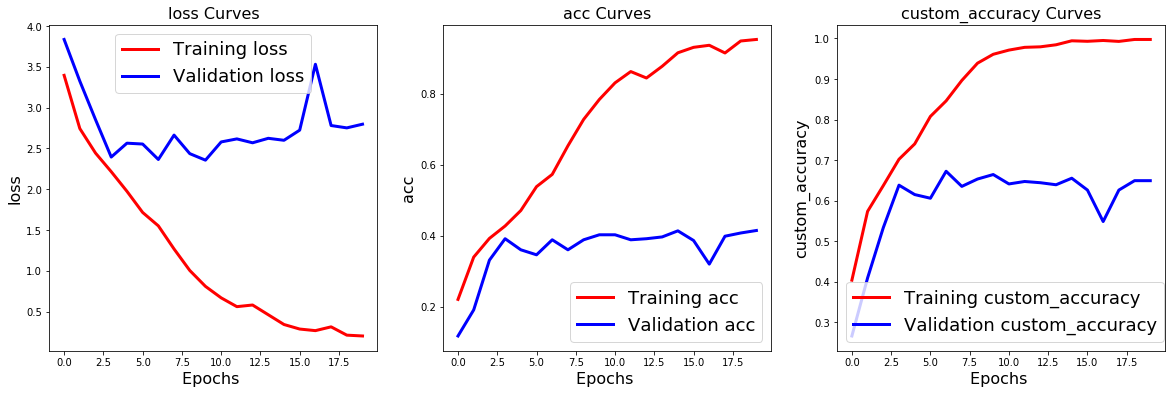

In [69]:
model4 = CNN4LayerModel(OUTPUTSHAPEFLICKR)
model4.compile_model()
#model4.summarise()
results = model4.get_results(X_flickr_train, y_flickr_train,X_flickr_val, y_flickr_val, X_flickr_test, y_flickr_test, verbose=0)
model4.plot_results()

In [70]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))
print('Top-4 Accuracy \t:',round(results['Test Top-4 Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.371
Top-4 Accuracy 	: 0.609


In [73]:
path_weights = './saved_models/model4/weights.h5'
path_model = './saved_models/model4/model.json'

#Save Model
model_json = model4.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model4.model.save_weights(path_weights)

In [74]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

<a id="Model5"></a>
## Model 5 - Transfer learning using Mobilenet V2

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 14:19:57.919125 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


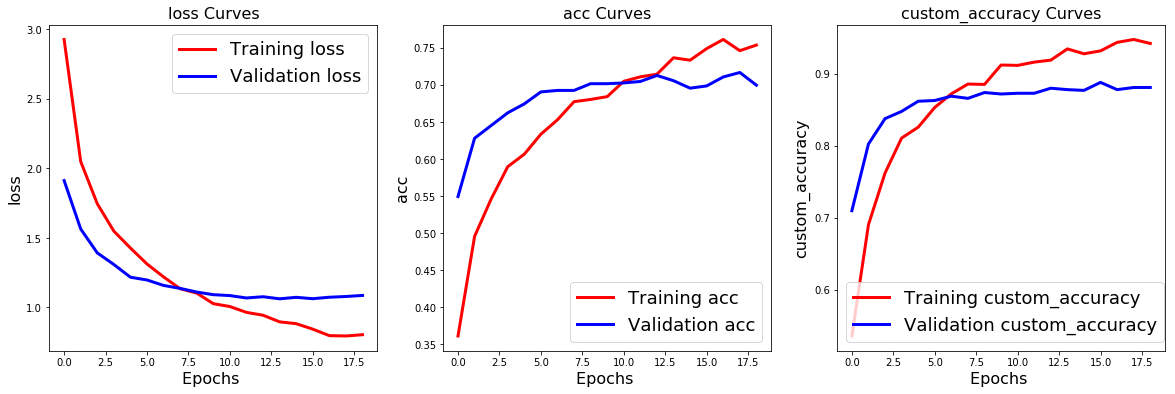

In [75]:
model5 = TransferLearningModel(OUTPUTSHAPEFLICKR)
model5.compile_model()
#model5.summarise()
results = model5.get_results(X_flickr_train, y_flickr_train,
                             X_flickr_val, y_flickr_val, 
                             X_flickr_test, y_flickr_test, verbose=0)
model5.plot_results()

In [76]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))
print('Top-4 Accuracy \t:',round(results['Test Top-4 Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.687
Top-4 Accuracy 	: 0.88


In [77]:
path_weights = './saved_models/model5/weights.h5'
path_model = './saved_models/model5/model.json'

#Note that the model does not save using the path save_model method. 
model5.model.save_weights(path_weights)

c:\users\johnr\anaconda3\envs\python35gpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


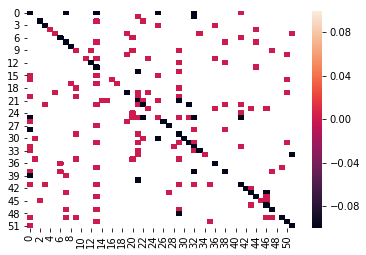

In [78]:
import seaborn as sns

y_predict = model5.model.predict_classes(X_flickr_test)
sns.heatmap(-np.log(confusion_matrix(y_flickr_test, y_predict)))

In [79]:
labels_predict = label_encoder_flickr.inverse_transform(y_predict)
labels_true = label_encoder_flickr.inverse_transform(y_flickr_test)

print(classification_report(labels_true, labels_predict))

                precision    recall  f1-score   support

         Apple       0.68      0.76      0.72        51
       Apricot       0.00      0.00      0.00         3
       Avocado       0.80      0.67      0.73         6
        Banana       0.92      0.92      0.92        25
  Cactus fruit       1.00      0.50      0.67         2
    Cantaloupe       0.50      0.25      0.33         4
     Carambula       0.67      0.67      0.67         6
        Cherry       0.45      0.62      0.53         8
      Chestnut       0.67      1.00      0.80         2
    Clementine       0.17      0.20      0.18         5
         Cocos       0.00      0.00      0.00         2
         Dates       1.00      0.25      0.40         4
    Granadilla       0.75      0.60      0.67         5
         Grape       0.79      0.98      0.88        59
    Grapefruit       0.00      0.00      0.00         4
         Guava       0.00      0.00      0.00         3
      Hazelnut       1.00      0.33      0.50  

c:\users\johnr\anaconda3\envs\python35gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

# Training a model on a reduced fruit subset <a id='ModellingSection3'></a>
## Model 6 - 4 Convolutional layers CNN <a id='Model6'></a>

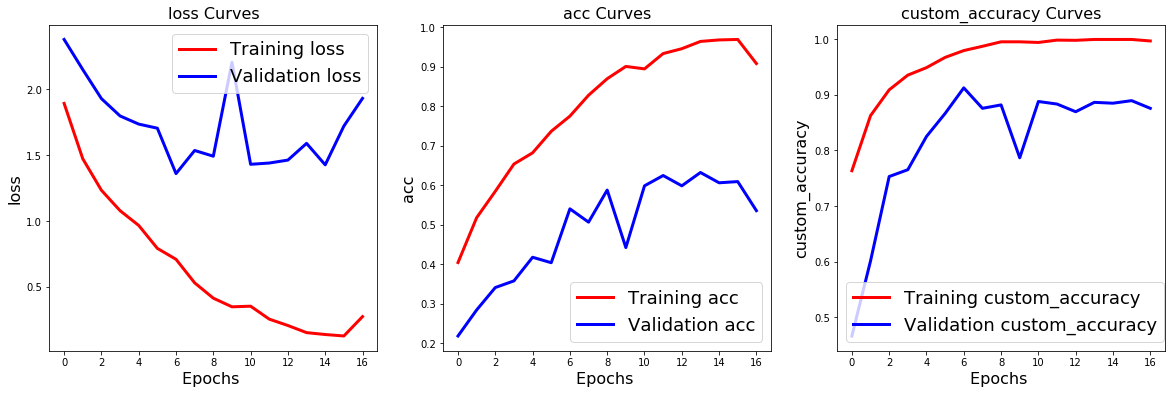

In [81]:
model6 = CNN4LayerModel(OUTPUTSHAPEFLICKRSUBSET)
model6.compile_model()
results = model6.get_results(X_flickr_subset_train, y_flickr_subset_train,
                             X_flickr_subset_val, y_flickr_subset_val, 
                             X_flickr_subset_test, y_flickr_subset_test, verbose=0)
model6.plot_results()

In [82]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))
print('Top-4 Accuracy \t:',round(results['Test Top-4 Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.586
Top-4 Accuracy 	: 0.909


In [83]:
path_weights = './saved_models/model6/weights.h5'
path_model = './saved_models/model6/model.json'

#Save Model
model_json = model6.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model6.model.save_weights(path_weights)

In [84]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

# Model 7 - Transfer learning using the Mobilenet V2 model <a id='Model7'></a>

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 14:30:31.738566 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Train on 2605 samples, validate on 652 samples
Epoch 1/100
2605/2605 [==============================] - 8s 3ms/step - loss: 1.4729 - acc: 0.5624 - custom_accuracy: 0.8250 - val_loss: 0.5929 - val_acc: 0.8221 - val_custom_accuracy: 0.9755
Epoch 2/100
2605/2605 [==============================] - 5s 2ms/step - loss: 0.7613 - acc: 0.7512 - custom_accuracy: 0.9578 - val_loss: 0.5188 - val_acc: 0.8328 - val_custom_accuracy: 0.9831
Epoch 3/100
2605/2605 [==============================] - 5s 2ms/step - loss: 0.6462 - acc: 0.7846 - custom_accuracy: 0.9697 - val_loss: 0.4745 - val_acc: 0.8436 - val_custom_accuracy: 0.9862
Epoch 4/100
2605/2605 [==============================] - 5s 2ms/step - loss: 0.5438 - acc: 0.8200 - custom_accuracy: 0.9785 - val_loss: 0.4492 - val_acc: 0.8558 - val_custom_accuracy: 0.9893
Epoch 5/100
2605/2605 [==============================] - 5s 2ms/step - loss: 0.5216 - acc: 0.8250 - custom_accuracy: 0.9816 - val_loss: 0.4413 - val_acc: 0.8635 - val_custom_accuracy: 0.984

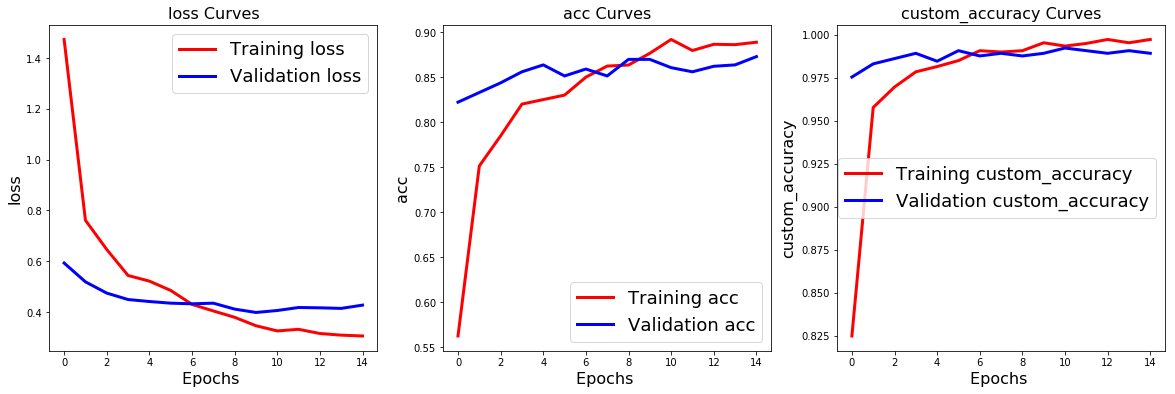

In [85]:
model7 = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET)
model7.compile_model()
#model7.summarise()
results = model7.get_results(X_flickr_subset_train, y_flickr_subset_train,
                             X_flickr_subset_val, y_flickr_subset_val, 
                             X_flickr_subset_test, y_flickr_subset_test, verbose=1)
model7.plot_results()

In [87]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))
print('Top-4 Accuracy \t:',round(results['Test Top-4 Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.851
Top-4 Accuracy 	: 0.994


In [88]:
path_weights = './saved_models/model7/weights.h5'
model7.model.save_weights(path_weights)

In [89]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

# Hyper parameter tuning <a id='Hyperparam'></a>

## Optimizer hyperparameter tuning

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 14:32:16.366180 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 0 Test Accuracy : 84.8 


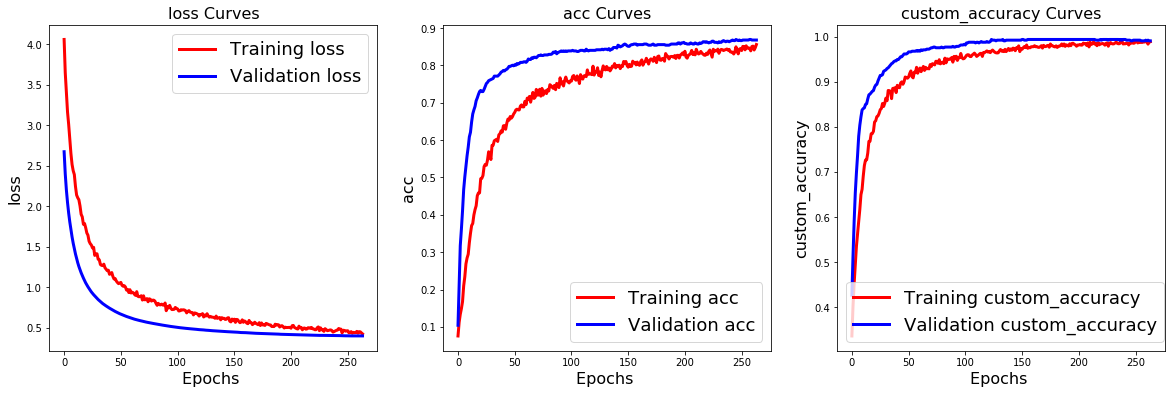

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 14:52:29.487440 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 0 Test Accuracy : 87.0 


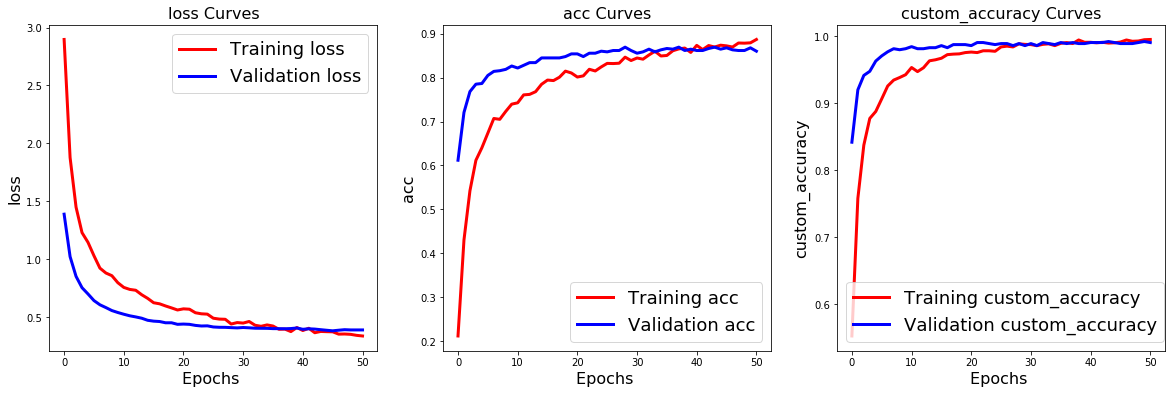

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 14:56:40.163431 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 0 Test Accuracy : 87.6 


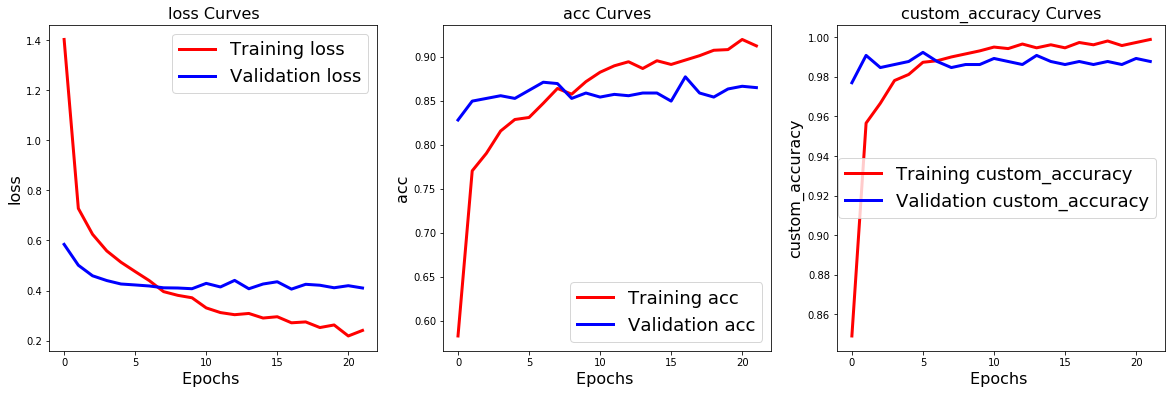

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 14:58:28.910484 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 0 Test Accuracy : 82.6 


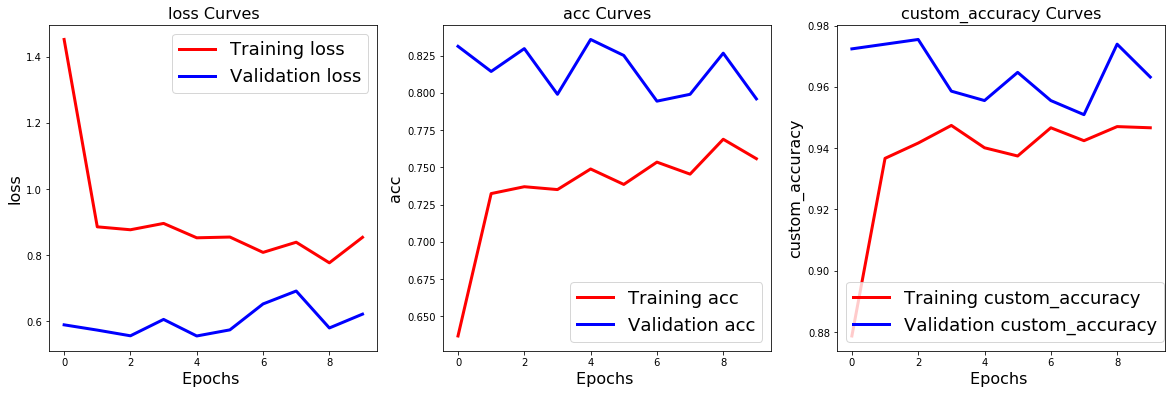

In [90]:
results = []
counter=0
for learningRate in [10**x for x in range(-4,-1)] :
    counter +=1
    optimiser = Adam(lr=learningRate)
    model = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET)
    model.compile_model(optimiser)
    model_results = model.get_results(X_flickr_subset_train, y_flickr_subset_train,
                                 X_flickr_subset_val, y_flickr_subset_val, 
                                 X_flickr_subset_test, y_flickr_subset_test, verbose=0, epochs=1000)
    print('Model : {}' .format(counter), 'Test Accuracy : {} ' .format(100*round(model_results['Test Accuracy'],3)))
    model.plot_results()
    plt.show()
    results.append({'Learning rate':learningRate,
                     'Test Accuracy': model_results['Test Accuracy']})
    K.clear_session() #reduces the memory footprint
    tf.reset_default_graph() #reduces the memory footprint
    
results = pd.DataFrame(results)

In [91]:
results = pd.DataFrame(results) #
results.to_csv('hyper-param.csv', sep='\t')

In [92]:
results.sort_values('Test Accuracy', ascending=False)

,Learning rate,Test Accuracy
2,0.00100,0.875691
1,0.00010,0.870166
0,0.00001,0.848066
3,0.01000,0.825967


### Grid search a number of alternative parameters for the model

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 14:59:39.873627 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 1 Test Accuracy : 85.39999999999999 


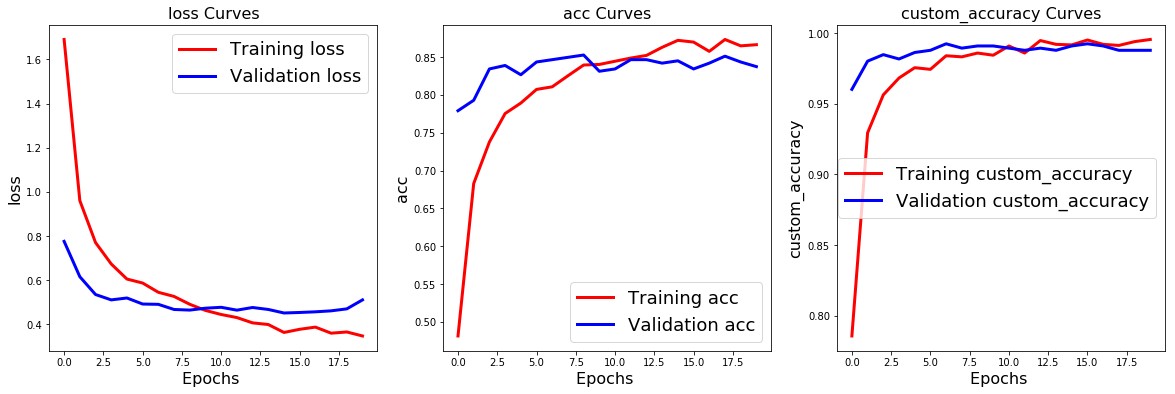

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:01:01.117590 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 2 Test Accuracy : 85.9 


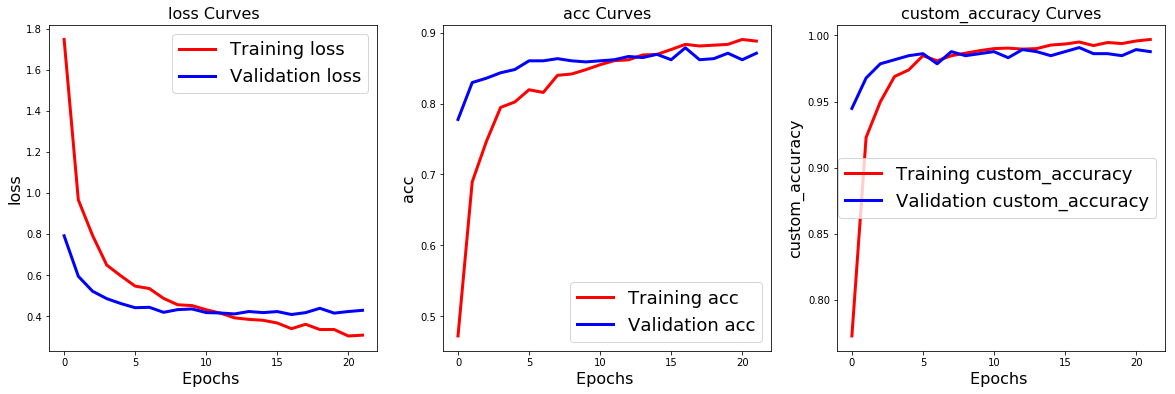

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:02:45.417480 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 3 Test Accuracy : 86.2 


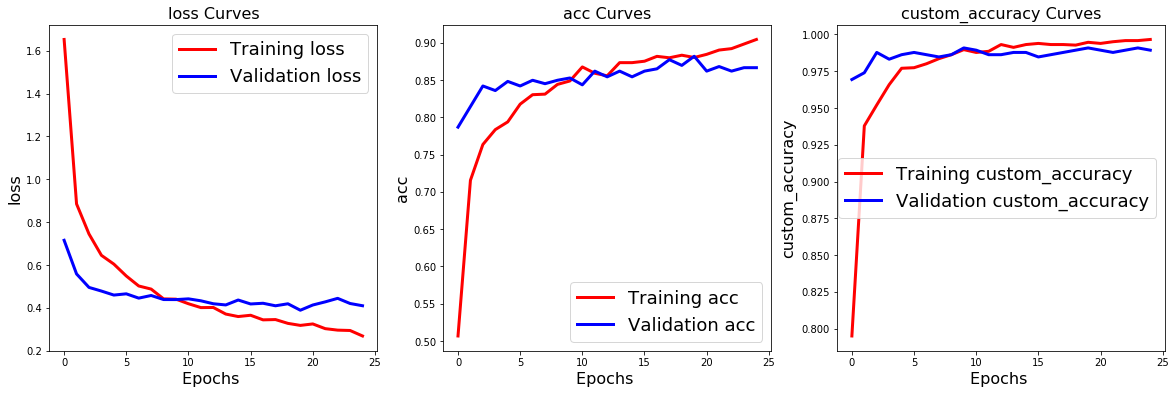

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:04:48.200112 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 4 Test Accuracy : 83.7 


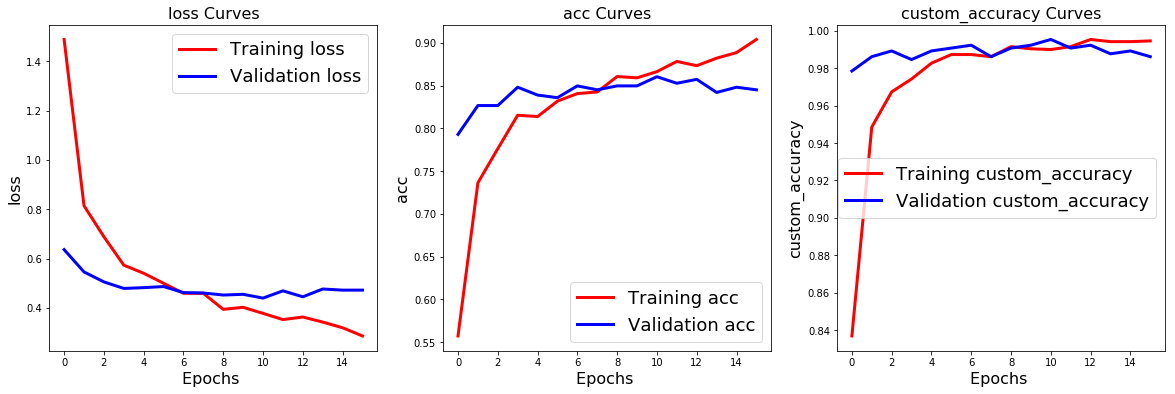

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:05:53.001739 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 5 Test Accuracy : 85.6 


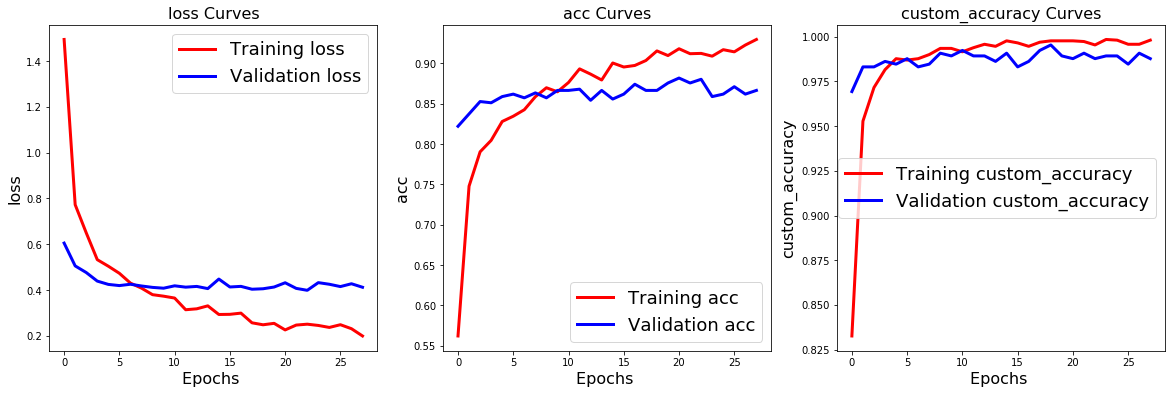

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:08:46.754302 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 6 Test Accuracy : 85.6 


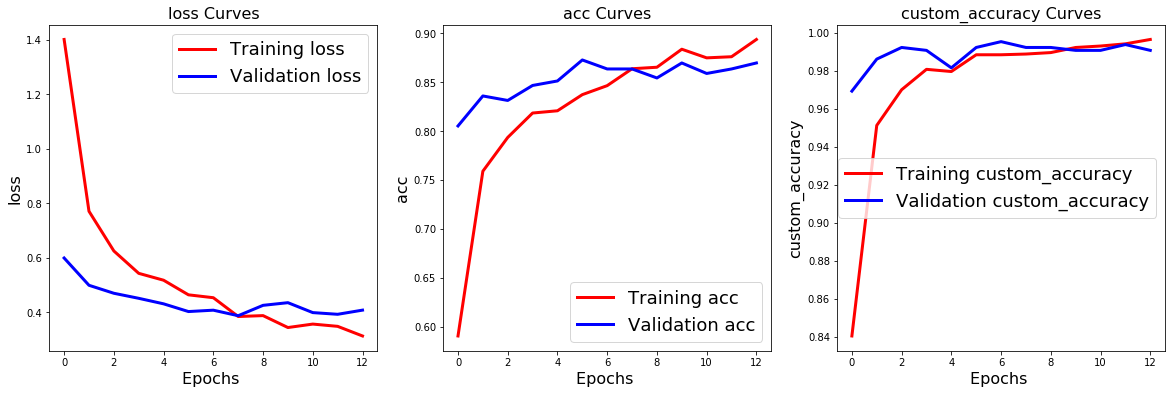

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:09:56.316227 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 7 Test Accuracy : 84.0 


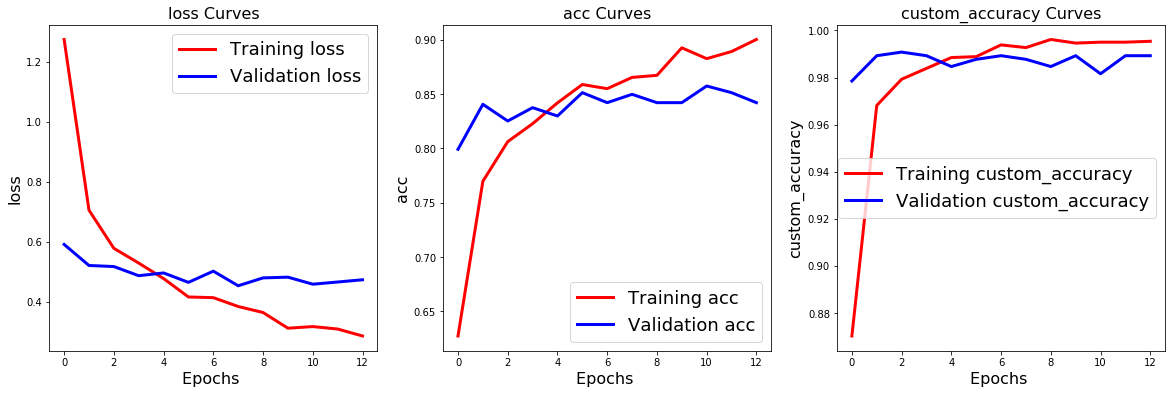

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:10:49.455024 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 8 Test Accuracy : 85.1 


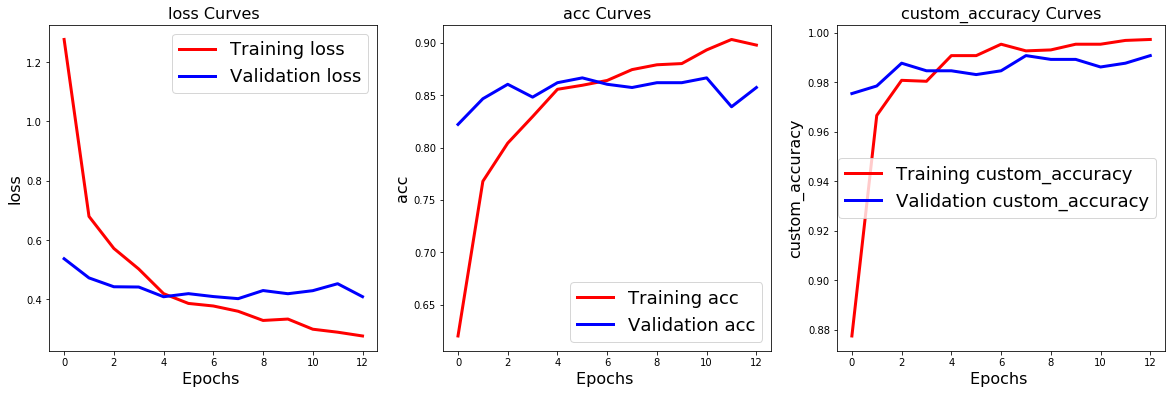

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:11:54.919877 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 9 Test Accuracy : 85.1 


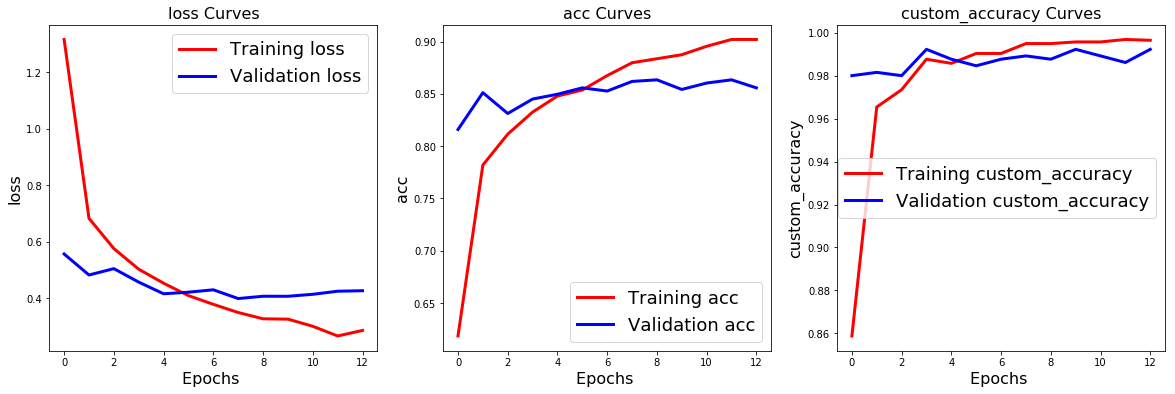

In [93]:
#Number of repeats for averaging:
repeats=1 

featureModels = ["https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2",
                "https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2",
                "https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2"]

results = []
counter=0
for dropout1 in [0.50]:
    for dropout2 in [0.50]:
        for denseNodes in [128,256,512]:
            for featureVectorString in featureModels:
                for repeat in range(repeats):
                    counter +=1
                    model = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET, 
                                                  dropout1, dropout2, 
                                                  denseNodes, featureVectorString)
                    optimiser = Adam(lr=0.001)
                    model.compile_model(optimiser)
                    model_results = model.get_results(X_flickr_subset_train, y_flickr_subset_train,
                                                 X_flickr_subset_val, y_flickr_subset_val, 
                                                 X_flickr_subset_test, y_flickr_subset_test, verbose=0, epochs=1000)
                    print('Model : {}' .format(counter), 'Test Accuracy : {} ' .format(100*round(model_results['Test Accuracy'],3)))
                    model.plot_results()
                    plt.show()
                    
                    results.append(model_results)
                    K.clear_session() #reduces the memory footprint
                    tf.reset_default_graph() #reduces the memory footprint
    
results = pd.DataFrame(results)

In [94]:
del results['self']
metrics = ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy',
           'Training Top-4 Accuracy', 'Validation Top-4 Accuracy', 'Test Top-4 Accuracy']

#group across all runs
non_metrics = [x for x in results.columns if x not in metrics]
grouped_results = results.groupby(by=non_metrics).mean()
grouped_results.sort_values('Test Accuracy', ascending=False)

Test Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                  
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.861878   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.859116   
256        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.856354   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.856354   
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.853591   
512        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.850829   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.850829   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.839779   
256        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.837017   

                                                                                             Test Top-4 Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                        
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.986188   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.991713   
256        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.980663   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.994475   
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.983425   
512        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.983425   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.994475   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.983425   
256        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.991713   

                                                                                             Training Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                      
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.904415   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.888292   
256        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.929750   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.893666   
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.866411   
512        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.897889   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.902111   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.900192   
256        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.904031   

                                                                                             Training Top-4 Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                            
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                          0.

In [95]:
results = pd.DataFrame(results) #
results.to_csv('hyperparam_network.csv', sep='\t')

# Model 8 - Making allowance for class imbalances

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:22:03.836823 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Train on 2605 samples, validate on 652 samples
Epoch 1/100
2605/2605 [==============================] - 13s 5ms/step - loss: 1.6440 - acc: 0.5079 - custom_accuracy: 0.7866 - val_loss: 0.7025 - val_acc: 0.7945 - val_custom_accuracy: 0.9617
Epoch 2/100
2605/2605 [==============================] - 5s 2ms/step - loss: 0.9140 - acc: 0.7113 - custom_accuracy: 0.9248 - val_loss: 0.5777 - val_acc: 0.8037 - val_custom_accuracy: 0.9724
Epoch 3/100
2605/2605 [==============================] - 5s 2ms/step - loss: 0.7709 - acc: 0.7497 - custom_accuracy: 0.9516 - val_loss: 0.4956 - val_acc: 0.8436 - val_custom_accuracy: 0.9877
Epoch 4/100
2605/2605 [==============================] - 5s 2ms/step - loss: 0.6515 - acc: 0.7923 - custom_accuracy: 0.9631 - val_loss: 0.4743 - val_acc: 0.8482 - val_custom_accuracy: 0.9893
Epoch 5/100
2605/2605 [==============================] - 5s 2ms/step - loss: 0.5558 - acc: 0.8131 - custom_accuracy: 0.9766 - val_loss: 0.4537 - val_acc: 0.8451 - val_custom_accuracy: 0.98

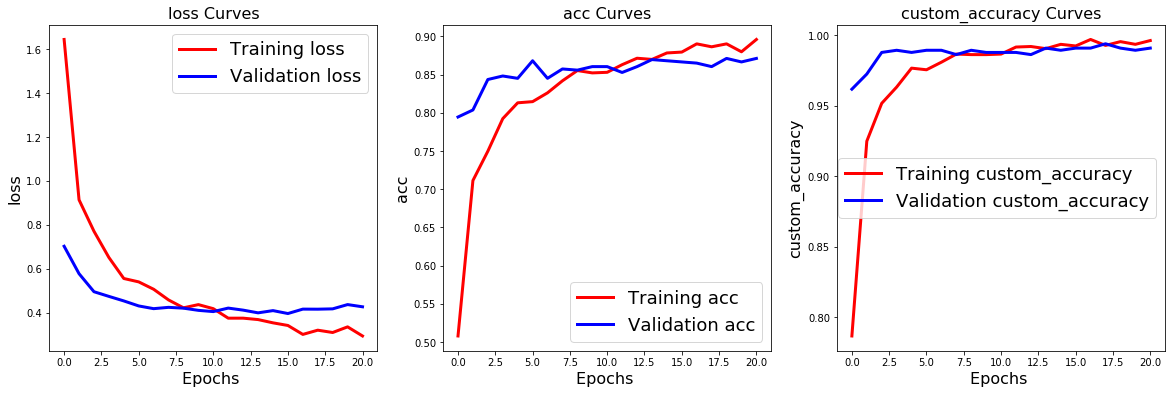

In [103]:
model8 = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET, dropout1=0.5, dropout2=0.5, denseNodes=128)
model8.compile_model()
results = model8.get_results(X_flickr_subset_train, y_flickr_subset_train,
                             X_flickr_subset_val, y_flickr_subset_val, 
                             X_flickr_subset_test, y_flickr_subset_test, verbose=1,
                            class_weight=class_weights_flickr_subset)
model8.plot_results()

In [104]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))
print('Top-4 Accuracy \t:',round(results['Test Top-4 Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.856
Top-4 Accuracy 	: 0.989


In [106]:
path_weights = './saved_models/model8/weights.h5'
model8.model.save_weights(path_weights)

##  General Comments <a id='Comments3'></a>

In [ ]:
TBC

# Model 9 -  Image Augmentation

In [117]:
model9 = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET, dropout1=0.5,dropout2=0.5, denseNodes=128)
optimizer=Adam(lr=0.001)
model9.compile_model(optimizer)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:37:29.506400 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [119]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    #zoom_range=[0.1,0.0],
    #width_shift_range=20,
    #height_shift_range=20,
    horizontal_flip=True)

datagen.fit(X_flickr_subset_train)

Epoch 1/1000
21/20 [==============================] - 19s 884ms/step - loss: 2.3800 - acc: 0.3310 - custom_accuracy: 0.6506 - val_loss: 1.1382 - val_acc: 0.7178 - val_custom_accuracy: 0.8880
Epoch 2/1000
21/20 [==============================] - 10s 466ms/step - loss: 1.2555 - acc: 0.6045 - custom_accuracy: 0.8651 - val_loss: 0.7750 - val_acc: 0.7745 - val_custom_accuracy: 0.9433
Epoch 3/1000
21/20 [==============================] - 11s 519ms/step - loss: 1.0158 - acc: 0.6885 - custom_accuracy: 0.9071 - val_loss: 0.6351 - val_acc: 0.7960 - val_custom_accuracy: 0.9739
Epoch 4/1000
21/20 [==============================] - 12s 590ms/step - loss: 0.8951 - acc: 0.7154 - custom_accuracy: 0.9302 - val_loss: 0.5714 - val_acc: 0.8175 - val_custom_accuracy: 0.9816
Epoch 5/1000
21/20 [==============================] - 12s 557ms/step - loss: 0.8109 - acc: 0.7382 - custom_accuracy: 0.9455 - val_loss: 0.5504 - val_acc: 0.8236 - val_custom_accuracy: 0.9847
Epoch 6/1000
21/20 [=========================

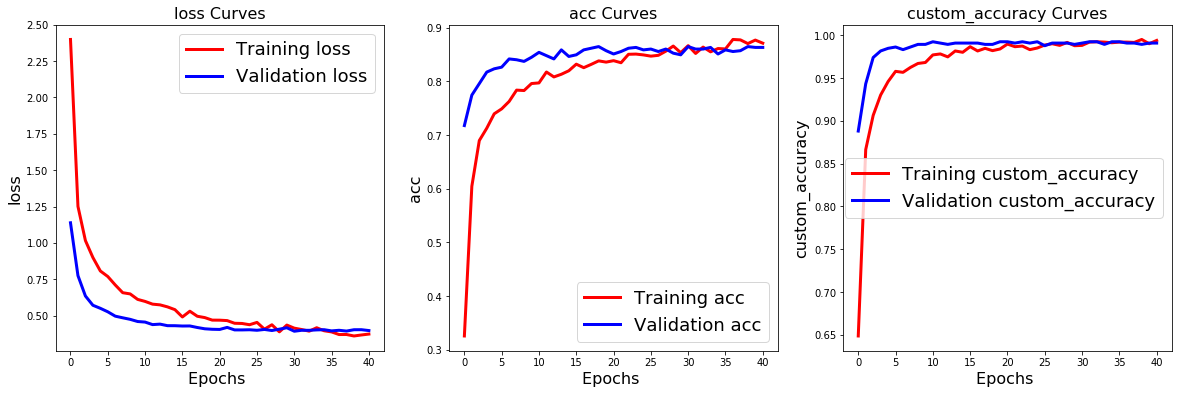

In [120]:
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=10, verbose=0, mode='auto')

history = model9.model.fit_generator(datagen.flow(X_flickr_subset_train, y_flickr_subset_train, batch_size=128),
                    steps_per_epoch=len(X_flickr_subset_train) / 128, epochs=1000,
                    callbacks=[cp_earlystop],
                    class_weight=class_weights_flickr_subset,
                    validation_data = (X_flickr_subset_val, y_flickr_subset_val), verbose=1)

plt_history(history)

In [121]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
results = model9.model.evaluate(X_flickr_subset_test, y_flickr_subset_test, verbose=0)
print('Accuracy \t:',results[1])
print('Top 4 Accuracy \t:',results[2])

The accuracy of the model on a test set:
Accuracy 	: [0.4089596871266049, 0.861878453038674, 0.9917127071823204]


In [123]:
path_weights = './saved_models/model9/weights.h5'

#Note, cannot save model with this version of Tensorflow
model9.model.save_weights(path_weights)

## Model 10 - Image Augmentation

In [124]:
model10 = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET, dropout1=0.5,dropout2=0.5, denseNodes=128)
optimizer=Adam(lr=0.001)
model10.compile_model(optimizer)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0325 15:53:33.335968 24004 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [132]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    zoom_range=0.3,
    #width_shift_range=20,
    #height_shift_range=20,
    horizontal_flip=True)

datagen.fit(X_flickr_subset_train)

Epoch 1/1000
11/10 [================================] - 12s 1s/step - loss: 0.4284 - acc: 0.8567 - custom_accuracy: 0.9882 - val_loss: 0.3757 - val_acc: 0.8696 - val_custom_accuracy: 0.9877
Epoch 2/1000
11/10 [================================] - 10s 891ms/step - loss: 0.3951 - acc: 0.8692 - custom_accuracy: 0.9928 - val_loss: 0.3844 - val_acc: 0.8635 - val_custom_accuracy: 0.9877
Epoch 3/1000
11/10 [================================] - 10s 927ms/step - loss: 0.4094 - acc: 0.8493 - custom_accuracy: 0.9939 - val_loss: 0.3997 - val_acc: 0.8574 - val_custom_accuracy: 0.9877
Epoch 4/1000
11/10 [================================] - 11s 976ms/step - loss: 0.4081 - acc: 0.8578 - custom_accuracy: 0.9920 - val_loss: 0.3944 - val_acc: 0.8635 - val_custom_accuracy: 0.9877
Epoch 5/1000
11/10 [================================] - 11s 1s/step - loss: 0.3892 - acc: 0.8689 - custom_accuracy: 0.9928 - val_loss: 0.3974 - val_acc: 0.8650 - val_custom_accuracy: 0.9862
Epoch 6/1000
11/10 [=====================

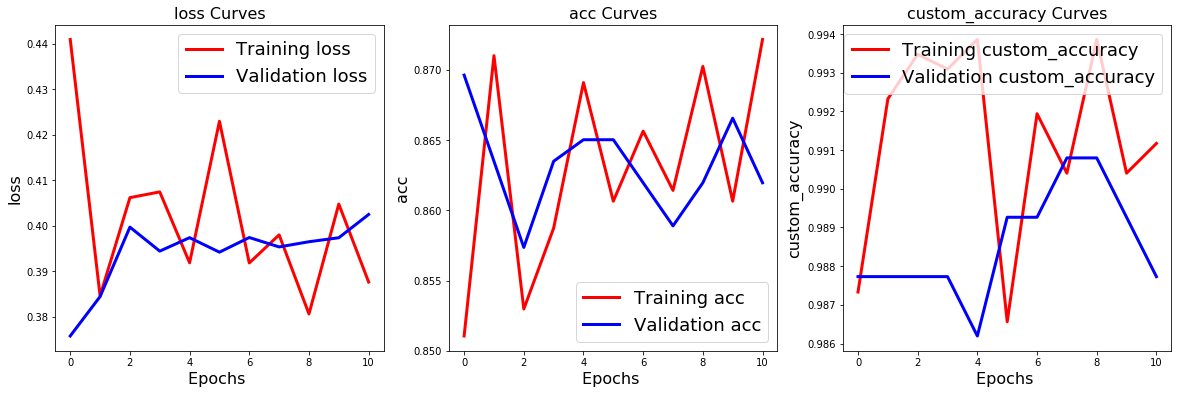

In [133]:
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=10, verbose=0, mode='auto')

history = model10.model.fit_generator(datagen.flow(X_flickr_subset_train, y_flickr_subset_train, batch_size=256),
                    steps_per_epoch=len(X_flickr_subset_train) / 256, epochs=1000,
                    callbacks=[cp_earlystop],
                    validation_data = (X_flickr_subset_val, y_flickr_subset_val), verbose=1)

plt_history(history)

In [134]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
results = model10.model.evaluate(X_flickr_subset_test, y_flickr_subset_test, verbose=0)
print('Accuracy \t:',results[1])
print('Top 4 Accuracy \t:',results[2])

The accuracy of the model on a test set:
Accuracy 	: 0.856353591160221
Top 4 Accuracy 	: 0.988950276243094


In [128]:
path_weights = './saved_models/model10/weights.h5'

#Note, cannot save model with this version of Tensorflow
model10.model.save_weights(path_weights)